# Intel Image Classification

Context

This is image data of Natural Scenes around the world.
Content

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.
Acknowledgements

Thanks to https://datahack.analyticsvidhya.com for the challenge and Intel for the Data

Photo by Jan Böttinger on Unsplash
Inspiration

Want to build powerful Neural network that can classify these images with more accuracy.

## Import library

In [15]:
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

In [16]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [17]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
print(tf.__version__)

2.19.0


## Data Loading

(download dataset manually)

Data Preparation

In [6]:
train_dir = "data/seg_train/seg_train"
# val_dir = "data/seg_test/seg_test"
test_dir = "data/seg_test/seg_test"

combined_dir = "data/seg_combined"

In [7]:
os.makedirs(combined_dir, exist_ok=True)

In [8]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

## Dataset Checking

In [9]:
scenes_image = {}

path = combined_dir
# path_sub = os.path.join(path, "dataset")
for i in os.listdir(path):
    scenes_image[i] = os.listdir(os.path.join(path, i))

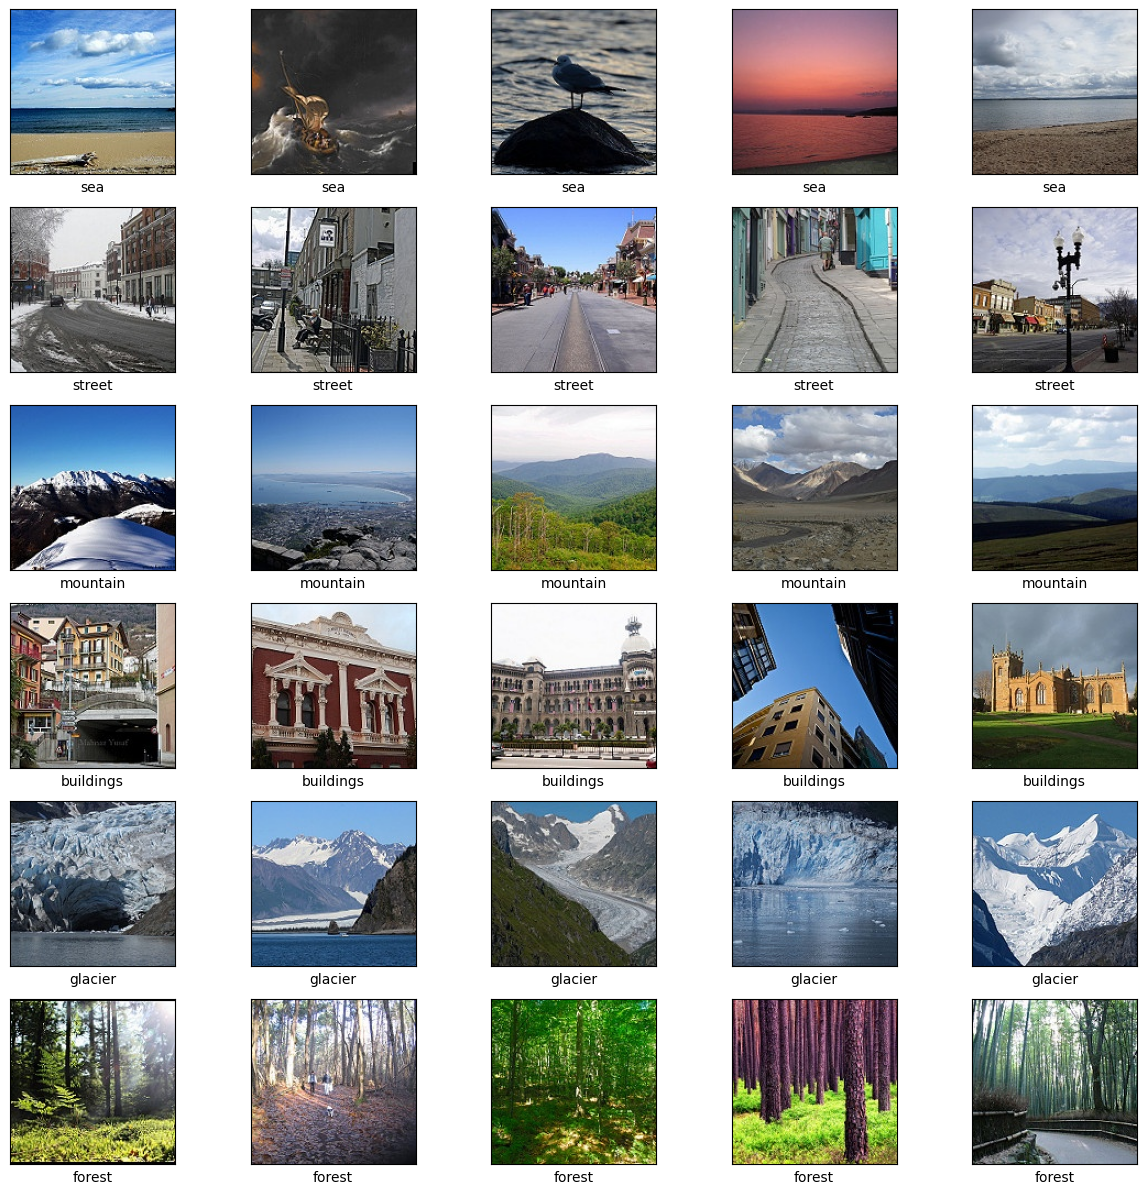

In [10]:
fig, axs = plt.subplots(len(scenes_image.keys()), 5, figsize=(15,15))

for i, class_name in enumerate(os.listdir(combined_dir)):
    images = np.random.choice(scenes_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(combined_dir, class_name, image_name)
        img = Image.open(img_path)
        # axs[i,j].imshow(img, cmap='gray')
        axs[i,j].imshow(img)
        axs[i,j].set(xlabel=class_name, xticks=[], yticks=[])

## Distribution plotting

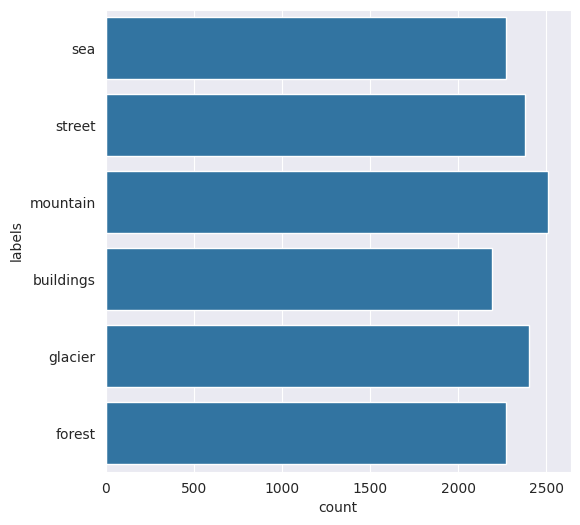

In [11]:
file_name = []
labels = []
full_path = []
 
for path, subdirs, files in os.walk(train_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
 
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)


In [12]:
distribution_train['labels'].value_counts().sum()

np.int64(14034)

In [13]:
distribution_train

path  file_name  labels
0          data/seg_train/seg_train/sea/4027.jpg   4027.jpg     sea
1         data/seg_train/seg_train/sea/18843.jpg  18843.jpg     sea
2         data/seg_train/seg_train/sea/10565.jpg  10565.jpg     sea
3         data/seg_train/seg_train/sea/16744.jpg  16744.jpg     sea
4         data/seg_train/seg_train/sea/15221.jpg  15221.jpg     sea
...                                          ...        ...     ...
14029  data/seg_train/seg_train/forest/12188.jpg  12188.jpg  forest
14030  data/seg_train/seg_train/forest/17051.jpg  17051.jpg  forest
14031   data/seg_train/seg_train/forest/9206.jpg   9206.jpg  forest
14032   data/seg_train/seg_train/forest/2014.jpg   2014.jpg  forest
14033    data/seg_train/seg_train/forest/409.jpg    409.jpg  forest

[14034 rows x 3 columns]

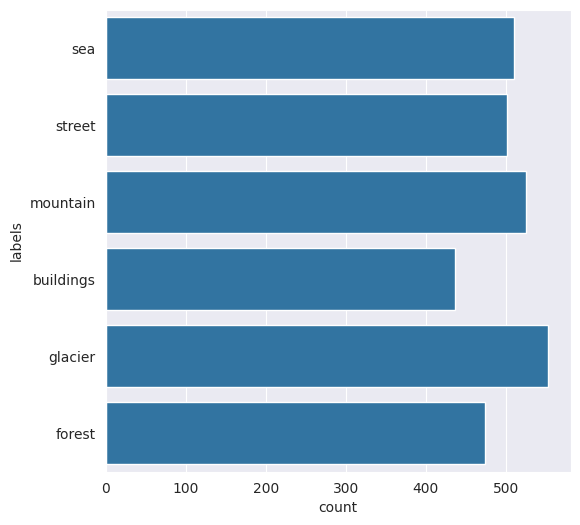

In [14]:
file_name = []
labels = []
full_path = []
 
for path, subdirs, files in os.walk(test_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
distribution_test = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
 
Label = distribution_test['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)


In [15]:
distribution_test['labels'].value_counts().sum()

np.int64(3000)

In [16]:
distribution_test

path  file_name  labels
0        data/seg_test/seg_test/sea/20633.jpg  20633.jpg     sea
1        data/seg_test/seg_test/sea/21598.jpg  21598.jpg     sea
2        data/seg_test/seg_test/sea/23841.jpg  23841.jpg     sea
3        data/seg_test/seg_test/sea/23786.jpg  23786.jpg     sea
4        data/seg_test/seg_test/sea/23135.jpg  23135.jpg     sea
...                                       ...        ...     ...
2995  data/seg_test/seg_test/forest/23698.jpg  23698.jpg  forest
2996  data/seg_test/seg_test/forest/23933.jpg  23933.jpg  forest
2997  data/seg_test/seg_test/forest/20900.jpg  20900.jpg  forest
2998  data/seg_test/seg_test/forest/22128.jpg  22128.jpg  forest
2999  data/seg_test/seg_test/forest/23070.jpg  23070.jpg  forest

[3000 rows x 3 columns]

## Data Augmentation

In [17]:
def anticlockwise_rotation(img):
    # Convert if needed
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    # Convert if needed
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    return rotate(img, -sudut)

def flip_up_down(img):
    # No color conversion needed for flipping
    img = cv2.resize(img, (224, 224))
    return np.flipud(img)

def add_brightness(img):
    # Convert if needed
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    
    img = cv2.resize(img, (224, 224))
    img = adjust_gamma(img, gamma=0.5, gain=1)
    return img

def blur_image(img):
    # Convert if needed
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    
    img = cv2.resize(img, (224, 224))
    return cv2.GaussianBlur(img, (9, 9), 0)

def sheared(img):
    # For warp functions, we don't need to convert to uint8
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    # For warp functions, we don't need to convert to uint8
    img = cv2.resize(img, (224, 224))
    transform = AffineTransform(translation=(0, 40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image


In [18]:
train_path = "data/seg_train/seg_train"
augmented_path = "data/seg_augmented"

transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness' : add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_to_generate = 300  # per class

for category in os.listdir(train_path):
    cat_path = os.path.join(train_path, category)
    aug_cat_path = os.path.join(augmented_path, category)
    
    os.makedirs(aug_cat_path, exist_ok=True)
    image_files = [os.path.join(cat_path, img) for img in os.listdir(cat_path)]
    
    i = 1
    while i <= images_to_generate:
        image_path = random.choice(image_files)
        try:
            img = io.imread(image_path)
            aug_img = img.copy()
            applied = []
            for _ in range(random.randint(1, len(transformations))):
                t = random.choice(list(transformations))
                while t in applied:
                    t = random.choice(list(transformations))
                aug_img = transformations[t](aug_img)
                applied.append(t)
            
            aug_img = img_as_ubyte(aug_img)
            if aug_img.ndim == 3 and aug_img.shape[2] == 3:
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

            out_path = os.path.join(aug_cat_path, f"aug_{i}.jpg")
            cv2.imwrite(out_path, aug_img)
            i += 1

        except Exception as e:
            print(f"Skipped {image_path}: {e}")


In [19]:
augmented_image = {}

augmented_path = "data/seg_augmented"

for i in os.listdir(augmented_path):
    category_path = os.path.join(augmented_path, i)
    if os.path.isdir(category_path):
        augmented_image[i] = os.listdir(category_path)

print("Augmented data found in each class:")
for k, v in augmented_image.items():
    print(k, len(v))


Augmented data found in each class:
sea 300
street 300
mountain 300
buildings 300
glacier 300
forest 300


In [20]:
print(augmented_image)

{'sea': ['aug_228.jpg', 'aug_186.jpg', 'aug_174.jpg', 'aug_277.jpg', 'aug_169.jpg', 'aug_24.jpg', 'aug_93.jpg', 'aug_8.jpg', 'aug_41.jpg', 'aug_117.jpg', 'aug_202.jpg', 'aug_184.jpg', 'aug_280.jpg', 'aug_204.jpg', 'aug_217.jpg', 'aug_151.jpg', 'aug_176.jpg', 'aug_145.jpg', 'aug_29.jpg', 'aug_70.jpg', 'aug_298.jpg', 'aug_84.jpg', 'aug_7.jpg', 'aug_194.jpg', 'aug_177.jpg', 'aug_252.jpg', 'aug_39.jpg', 'aug_167.jpg', 'aug_190.jpg', 'aug_58.jpg', 'aug_158.jpg', 'aug_87.jpg', 'aug_132.jpg', 'aug_207.jpg', 'aug_18.jpg', 'aug_156.jpg', 'aug_78.jpg', 'aug_47.jpg', 'aug_159.jpg', 'aug_263.jpg', 'aug_133.jpg', 'aug_91.jpg', 'aug_89.jpg', 'aug_251.jpg', 'aug_127.jpg', 'aug_52.jpg', 'aug_154.jpg', 'aug_4.jpg', 'aug_285.jpg', 'aug_227.jpg', 'aug_235.jpg', 'aug_3.jpg', 'aug_230.jpg', 'aug_66.jpg', 'aug_264.jpg', 'aug_90.jpg', 'aug_219.jpg', 'aug_243.jpg', 'aug_214.jpg', 'aug_6.jpg', 'aug_165.jpg', 'aug_157.jpg', 'aug_43.jpg', 'aug_211.jpg', 'aug_131.jpg', 'aug_83.jpg', 'aug_40.jpg', 'aug_19.jpg', 'a

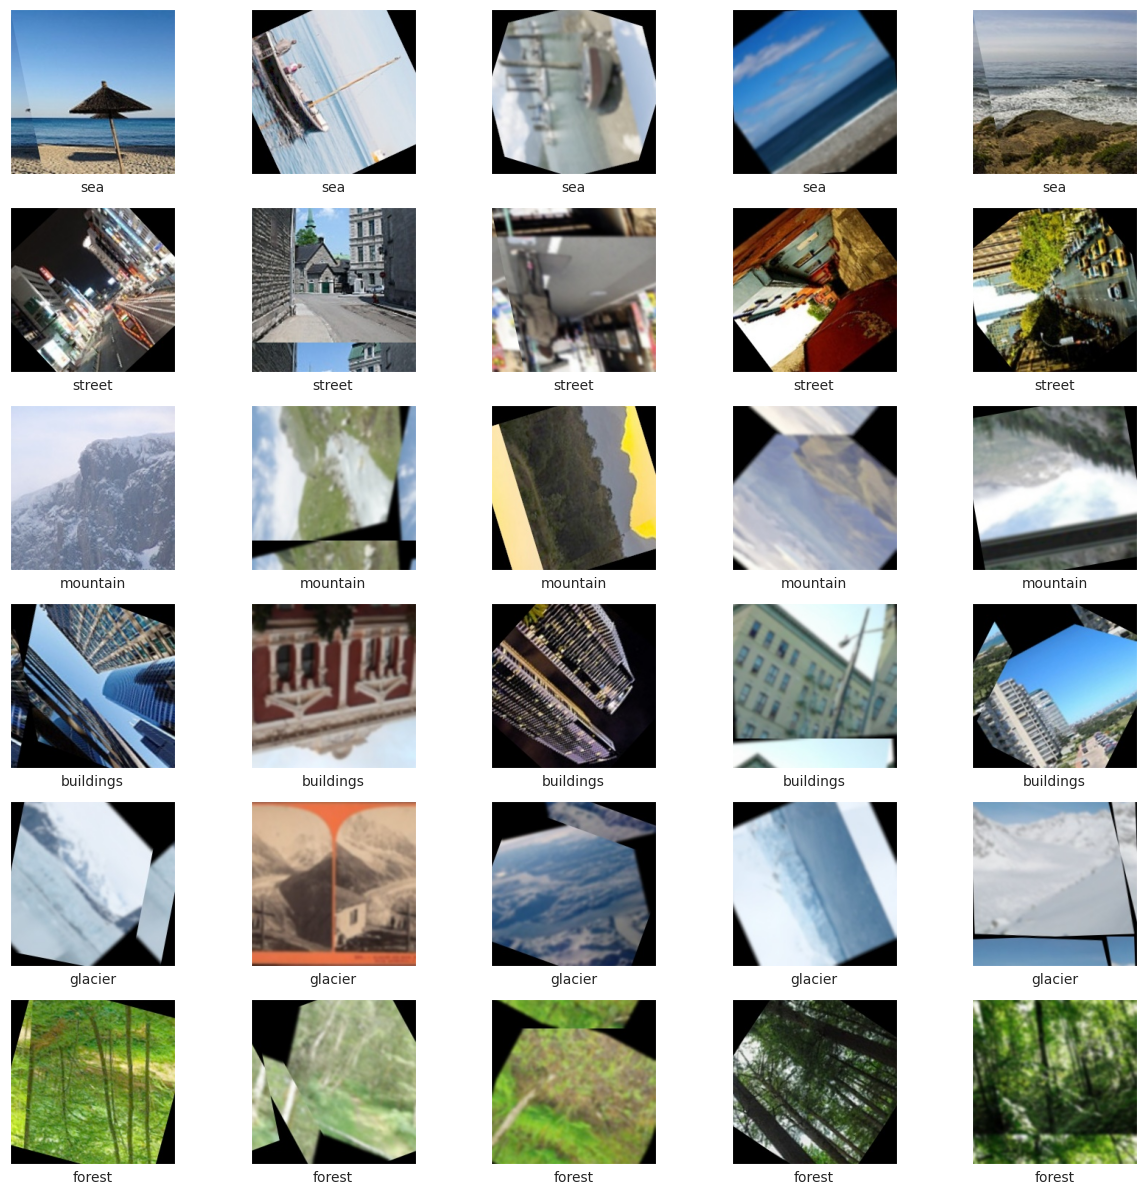

In [21]:
fig, axs = plt.subplots(len(augmented_image), 5, figsize=(15, 15))

for i, class_name in enumerate(augmented_image.keys()):
    images = np.random.choice(augmented_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(augmented_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


Combine augmented into train

In [22]:
augmented_path = "data/seg_augmented"
train_path = "data/seg_train/seg_train"

for category in os.listdir(augmented_path):
    source_dir = os.path.join(augmented_path, category)
    target_dir = os.path.join(train_path, category)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        print(f"Created target directory: {target_dir}")
    
    for image in os.listdir(source_dir):
        src_file = os.path.join(source_dir, image)
        dst_file = os.path.join(target_dir, image)
        
        if not os.path.exists(dst_file):  
            shutil.copy2(src_file, dst_file)


In [23]:
file_name = []
labels = []
full_path = []
 
for path, subdirs, files in os.walk(train_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
 

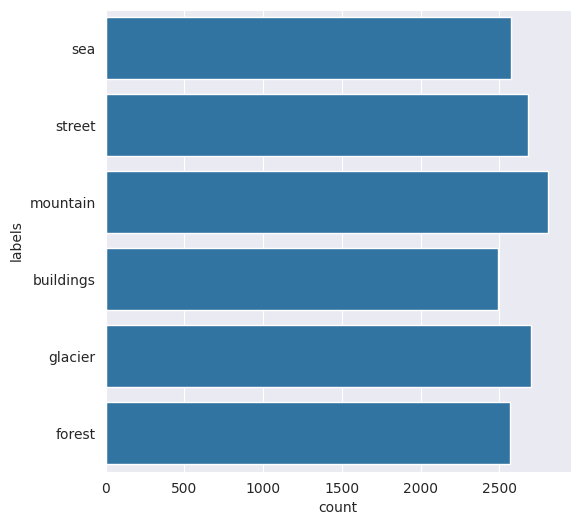

In [24]:
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Data Splitting

In [25]:
train_df = distribution_train.copy()
test_df = distribution_test.copy()

In [26]:
train_df.head()

path    file_name labels
0  data/seg_train/seg_train/sea/aug_228.jpg  aug_228.jpg    sea
1     data/seg_train/seg_train/sea/4027.jpg     4027.jpg    sea
2    data/seg_train/seg_train/sea/18843.jpg    18843.jpg    sea
3    data/seg_train/seg_train/sea/10565.jpg    10565.jpg    sea
4    data/seg_train/seg_train/sea/16744.jpg    16744.jpg    sea

In [27]:
train_df.groupby(['labels']).size()

labels
buildings    2491
forest       2571
glacier      2704
mountain     2812
sea          2574
street       2682
dtype: int64

In [28]:
test_df.groupby(['labels']).size()

labels
buildings    437
forest       474
glacier      553
mountain     525
sea          510
street       501
dtype: int64

In [29]:
X_train = train_df['path']
y_train = train_df['labels']

X_test = test_df['path']
y_test = test_df['labels']

In [30]:
df_tr = pd.DataFrame({'path': X_train, 'labels':y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set':'test'})

In [31]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))



set    labels   
test   buildings     437
       forest        474
       glacier       553
       mountain      525
       sea           510
       street        501
train  buildings    2491
       forest       2571
       glacier      2704
       mountain     2812
       sea          2574
       street       2682
dtype: int64 


                                             path   labels    set
99         data/seg_train/seg_train/sea/10789.jpg      sea  train
10614   data/seg_train/seg_train/glacier/2282.jpg  glacier  train
12108   data/seg_train/seg_train/glacier/9054.jpg  glacier  train
18755     data/seg_test/seg_test/forest/23373.jpg   forest   test
12534  data/seg_train/seg_train/glacier/15410.jpg  glacier  train


## Image Data Generator

In [6]:
TRAIN_DIR = "data/seg_train/seg_train"
TEST_DIR = "data/seg_test/seg_test"


datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)
 
train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                            #   color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)
 
validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                # color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)
 
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                #   color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)



Found 12670 images belonging to 6 classes.
Found 3164 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Pembangunan Model dengan Beberapa Skema Parameter Tuning

### Skema CNN Architecture dengan 32 Neurons pada Conv Layer

In [33]:
# tf.keras.backend.clear_session()
    
####################### Init sequential model ##################################
model_1 = Sequential()
    
# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
    
# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
    
# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))
    
# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))
    
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(6, activation='softmax'))
######################### Fully Connected Layer ################################
    
######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
# Summary of the Model Architecture
print(model_1.summary())

/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-14 21:27:05.073818: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,403,782 (5.36 MB)

 Trainable params: 1,403,590 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from the generator
class_indices = train_generator.class_indices  
class_names = list(class_indices.keys())
num_classes = len(class_names)


# List of class labels for all images in the training generator
labels = train_generator.classes 
print("Labels:", labels)

# Compute class weights
class_weights_list = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights_list))

print("Class Weights:", class_weights)



Labels: [0 0 0 ... 5 5 5]
Class Weights: {0: np.float64(1.0676934778474996), 1: np.float64(1.0300862227114291), 2: np.float64(0.9727997227997228), 3: np.float64(0.9311774461028193), 4: np.float64(1.0283882783882783), 5: np.float64(0.9819867086393844)}


In [35]:
# history_1 = model_1.fit(train_generator,
#                         epochs=30,
#                         batch_size=32,
#                         validation_data=validation_generator,
#                         class_weight=class_weights)

[1m396/396[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1383s[0m 3s/step - accuracy: 0.3124 - loss: 2.7446 - val_accuracy: 0.4450 - val_loss: 1.3884
Epoch 2/30
[1m396/396[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1595s[0m 4s/step - accuracy: 0.4223 - loss: 1.4399 - val_accuracy: 0.5341 - val_loss: 1.3271
Epoch 3/30
[1m396/396[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1588s[0m 4s/step - accuracy: 0.4979 - loss: 1.2408 - val_accuracy: 0.6410 - val_loss: 0.9606
Epoch 4/30
[1m396/396[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1351s[0m 3s/step - accuracy: 0.5397 - loss: 1.1517 - val_accuracy: 0.5866 - val_loss: 1.0963
Epoch 5/30
[1m396/396[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1409s[0m 4s/step - accuracy: 0.5877 - loss: 1.0565 - val_accuracy: 0.7067 - val_loss: 0.7854
Epoch 6/30
[1m396/396[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1464s[0m 4s/step - accuracy: 0.6330 - loss: 0.9628 - val_accuracy: 0.6931 - val_loss: 0.8063
Epoch 7/30
[1m396/396[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1302s[0m 3s/step - accuracy: 0.6459 - loss: 0.9461 - val_accuracy: 0.7007 - val_loss: 0.8087
Epoch 8/30
[1m 15/396[0m [37m━━━━━━━━━━━━━━━━━━━━[0m [1m20:36[0m 3s/step - accuracy: 0.6976 - loss: 0.8343

In [36]:
# model_1.save('model_checkpoint_epoch7.h5')

In [38]:
# loaded_model = tf.keras.models.load_model('model_checkpoint_epoch7.h5')
loaded_model = tf.keras.models.load_model('model_checkpoints/model_epoch_12.h5')
# /home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/PengembanganMachineLearning/finalProject/model_checkpoints/model_epoch_12.h5

model = tf.keras.models.clone_model(loaded_model)

model.set_weights(loaded_model.get_weights())

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),  
    loss='categorical_crossentropy',
    metrics=['accuracy']  
)

In [28]:
checkpoint_dir = './model_checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)


In [40]:
history_1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    # initial_epoch=7,
    initial_epoch=12,
    callbacks=[checkpoint_callback]
)

model.save('final_model_1.h5')

/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 13/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7187 - loss: 0.7922
Epoch 13: saving model to ./model_checkpoints/model_epoch_13.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 983s 2s/step - accuracy: 0.7187 - loss: 0.7922 - val_accuracy: 0.7099 - val_loss: 0.8279
Epoch 14/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7287 - loss: 0.7457
Epoch 14: saving model to ./model_checkpoints/model_epoch_14.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 959s 2s/step - accuracy: 0.7288 - loss: 0.7457 - val_accuracy: 0.7045 - val_loss: 0.7898
Epoch 15/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7360 - loss: 0.7115
Epoch 15: saving model to ./model_checkpoints/model_epoch_15.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 964s 2s/step - accuracy: 0.7360 - loss: 0.7116 - val_accuracy: 0.7753 - val_loss: 1.3183
Epoch 16/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7444 - loss: 0.7144
Epoch 16: saving model to ./model_checkpoints/model_epoch_16.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 957s 2s/step - accuracy: 0.7444 - loss: 0.7144 - val_accuracy: 0.7781 - val_loss: 0.6555
Epoch 17/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7427 - loss: 0.6903
Epoch 17: saving model to ./model_checkpoints/model_epoch_17.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 960s 2s/step - accuracy: 0.7428 - loss: 0.6903 - val_accuracy: 0.7898 - val_loss: 0.7188
Epoch 18/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7613 - loss: 0.6857
Epoch 18: saving model to ./model_checkpoints/model_epoch_18.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 915s 2s/step - accuracy: 0.7613 - loss: 0.6858 - val_accuracy: 0.7516 - val_loss: 1.4168
Epoch 19/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7568 - loss: 0.6739
Epoch 19: saving model to ./model_checkpoints/model_epoch_19.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 930s 2s/step - accuracy: 0.7568 - loss: 0.6739 - val_accuracy: 0.7690 - val_loss: 0.7058
Epoch 20/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7635 - loss: 0.6582
Epoch 20: saving model to ./model_checkpoints/model_epoch_20.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 974s 2s/step - accuracy: 0.7635 - loss: 0.6581 - val_accuracy: 0.7649 - val_loss: 0.6666
Epoch 21/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7780 - loss: 0.6053
Epoch 21: saving model to ./model_checkpoints/model_epoch_21.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.7780 - loss: 0.6054 - val_accuracy: 0.8050 - val_loss: 0.9333
Epoch 22/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7785 - loss: 0.6102
Epoch 22: saving model to ./model_checkpoints/model_epoch_22.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - accuracy: 0.7785 - loss: 0.6102 - val_accuracy: 0.7949 - val_loss: 0.6616
Epoch 23/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7775 - loss: 0.6214
Epoch 23: saving model to ./model_checkpoints/model_epoch_23.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 922s 2s/step - accuracy: 0.7776 - loss: 0.6214 - val_accuracy: 0.7974 - val_loss: 0.8416
Epoch 24/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7875 - loss: 0.5881
Epoch 24: saving model to ./model_checkpoints/model_epoch_24.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 957s 2s/step - accuracy: 0.7875 - loss: 0.5881 - val_accuracy: 0.7617 - val_loss: 0.8393
Epoch 25/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7940 - loss: 0.5856
Epoch 25: saving model to ./model_checkpoints/model_epoch_25.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 957s 2s/step - accuracy: 0.7940 - loss: 0.5856 - val_accuracy: 0.7427 - val_loss: 1.5537
Epoch 26/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7916 - loss: 0.5819
Epoch 26: saving model to ./model_checkpoints/model_epoch_26.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 960s 2s/step - accuracy: 0.7916 - loss: 0.5819 - val_accuracy: 0.7920 - val_loss: 0.7518
Epoch 27/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7962 - loss: 0.5642
Epoch 27: saving model to ./model_checkpoints/model_epoch_27.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 924s 2s/step - accuracy: 0.7963 - loss: 0.5641 - val_accuracy: 0.8003 - val_loss: 0.9428
Epoch 28/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8047 - loss: 0.5390
Epoch 28: saving model to ./model_checkpoints/model_epoch_28.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.8047 - loss: 0.5390 - val_accuracy: 0.7958 - val_loss: 0.7514
Epoch 29/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8047 - loss: 0.5318
Epoch 29: saving model to ./model_checkpoints/model_epoch_29.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - accuracy: 0.8047 - loss: 0.5319 - val_accuracy: 0.8375 - val_loss: 0.8703
Epoch 30/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8104 - loss: 0.5151
Epoch 30: saving model to ./model_checkpoints/model_epoch_30.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 920s 2s/step - accuracy: 0.8104 - loss: 0.5151 - val_accuracy: 0.8284 - val_loss: 0.9072


In [ ]:
model.save('final_improved_model_1.h5')

#### Plot

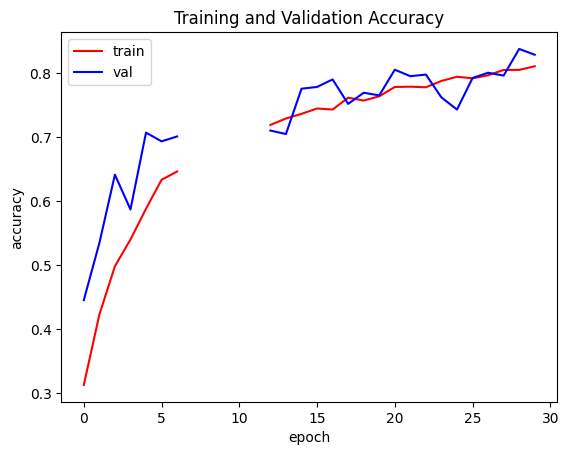

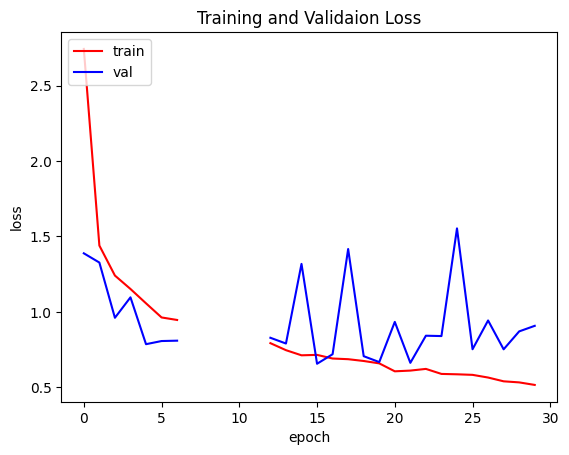

In [6]:
# acc = history_1.history['accuracy']
# val_acc = history_1.history['val_accuracy']
# loss = history_1.history['loss']
# val_loss = history_1.history['val_loss']
    
# Training accuracy values
acc = [0.3124, 0.4223, 0.4979, 0.5397, 0.5877, 0.6330, 0.6459, None, None, None, None, None, 0.7187, 0.7288, 0.7360, 0.7444, 0.7428, 0.7613, 0.7568, 0.7635, 0.7780, 0.7785, 0.7776, 0.7875, 0.7940, 0.7916, 0.7963, 0.8047, 0.8047, 0.8104]

# Validation accuracy values
val_acc = [0.4450, 0.5341, 0.6410, 0.5866, 0.7067, 0.6931, 0.7007, None, None, None, None, None, 0.7099, 0.7045, 0.7753, 0.7781, 0.7898, 0.7516, 0.7690, 0.7649, 0.8050, 0.7949, 0.7974, 0.7617, 0.7427, 0.7920, 0.8003, 0.7958, 0.8375, 0.8284]

# Training loss values
loss = [2.7446, 1.4399, 1.2408, 1.1517, 1.0565, 0.9628, 0.9461, None, None, None, None, None, 0.7922, 0.7457, 0.7116, 0.7144, 0.6903, 0.6858, 0.6739, 0.6581, 0.6054, 0.6102, 0.6214, 0.5881, 0.5856, 0.5819, 0.5641, 0.5390, 0.5319, 0.5151]

# Validation loss values
val_loss = [1.3884, 1.3271, 0.9606, 1.0963, 0.7854, 0.8063, 0.8087, None, None, None, None, None, 0.8279, 0.7898, 1.3183, 0.6555, 0.7188, 1.4168, 0.7058, 0.6666, 0.9333, 0.6616, 0.8416, 0.8393, 1.5537, 0.7518, 0.9428, 0.7514, 0.8703, 0.9072]

epochs = range(len(acc))
    
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
    
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



#### Model evaluation

In [7]:
loaded_model = tf.keras.models.load_model('final_model_1.h5')
# /home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/PengembanganMachineLearning/finalProject/model_checkpoints/model_epoch_12.h5

model_1 = tf.keras.models.clone_model(loaded_model)

2025-04-15 08:19:10.917695: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
test_loss, test_accuracy = model_1.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 67s 22ms/step - accuracy: 0.2301 - loss: 1.7956
Test Accuracy: 0.2220
Test Loss: 1.7869


In [9]:
test_loss, test_accuracy = model_1.evaluate(validation_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 54s 550ms/step - accuracy: 0.2116 - loss: 1.7969
Test Accuracy: 0.2089
Test Loss: 1.7882


In [10]:
print(f"Training generator class indices: {train_generator.class_indices}")
print(f"Validation generator class indices: {validation_generator.class_indices}")
print(f"Test generator class indices: {test_generator.class_indices}")

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Training generator class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Validation generator class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Test generator class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Training samples: 12670
Validation samples: 3164
Test samples: 3000


#### Analisis penyebab rendahnya akurasi

Menurut saya hasil evaluasi tidak sesuai karena dataset yang digunakan berubah ubah (ini terjadi karena saya menghapus dataset sebelum melakukan run ulang, kemudian melanjutkan load model dengan data yang berbeda). Sekarang saya akan memperbaikinya dengan tidak melakukan run ulang pada dataset yang ada.

In [11]:
train_classes = np.array(train_generator.classes)
val_classes = np.array(validation_generator.classes)
test_classes = np.array(test_generator.classes)

for i, class_name in enumerate(train_generator.class_indices.keys()):
    print(f"Class {class_name}: " 
          f"Train: {np.sum(train_classes == i)} ({np.sum(train_classes == i)/len(train_classes):.2%}), "
          f"Val: {np.sum(val_classes == i)} ({np.sum(val_classes == i)/len(val_classes):.2%}), "
          f"Test: {np.sum(test_classes == i)} ({np.sum(test_classes == i)/len(test_classes):.2%})")

Class buildings: Train: 1993 (15.73%), Val: 498 (15.74%), Test: 437 (14.57%)
Class forest: Train: 2057 (16.24%), Val: 514 (16.25%), Test: 474 (15.80%)
Class glacier: Train: 2164 (17.08%), Val: 540 (17.07%), Test: 553 (18.43%)
Class mountain: Train: 2250 (17.76%), Val: 562 (17.76%), Test: 525 (17.50%)
Class sea: Train: 2060 (16.26%), Val: 514 (16.25%), Test: 510 (17.00%)
Class street: Train: 2146 (16.94%), Val: 536 (16.94%), Test: 501 (16.70%)


In [12]:
print(f"Model weights shape: {model_1.get_weights()[0].shape}")
print(f"Last layer shape: {model_1.get_weights()[-1].shape}")

Model weights shape: (3, 3, 3, 32)
Last layer shape: (6,)


In [13]:
test_predictions = model_1.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

for i, class_name in enumerate(test_generator.class_indices.keys()):
    print(f"Class {class_name}: predicted {np.sum(predicted_classes == i)} times ({np.sum(predicted_classes == i)/len(predicted_classes):.2%})")

from sklearn.metrics import confusion_matrix, classification_report
true_classes = test_generator.classes[:len(predicted_classes)] 
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

report = classification_report(true_classes, predicted_classes, 
                              target_names=list(test_generator.class_indices.keys()))
print("Classification Report:")
print(report)

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step
Class buildings: predicted 0 times (0.00%)
Class forest: predicted 489 times (16.30%)
Class glacier: predicted 2439 times (81.30%)
Class mountain: predicted 11 times (0.37%)
Class sea: predicted 6 times (0.20%)
Class street: predicted 55 times (1.83%)
Confusion Matrix:
[[  0  70 356   1   2   8]
 [  0 143 329   1   0   1]
 [  0  32 507   0   1  13]
 [  0  51 465   1   0   8]
 [  0  67 428   3   1  11]
 [  0 126 354   5   2  14]]
Classification Report:
              precision    recall  f1-score   support

   buildings       0.00      0.00      0.00       437
      forest       0.29      0.30      0.30       474
     glacier       0.21      0.92      0.34       553
    mountain       0.09      0.00      0.00       525
         sea       0.17      0.00      0.00       510
      street       0.25      0.03      0.05       501

    accuracy                           0.22      3000
   macro avg       0.17      0.21      0.12      3000
weighted av

/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

In [14]:
test_generator.reset()
# Get a batch of images and true labels
x_batch, y_batch = next(test_generator)

# Predict on the batch
y_pred = model_1.predict(x_batch)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_batch, axis=1)

# Map indices to class names
class_names = list(test_generator.class_indices.keys())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


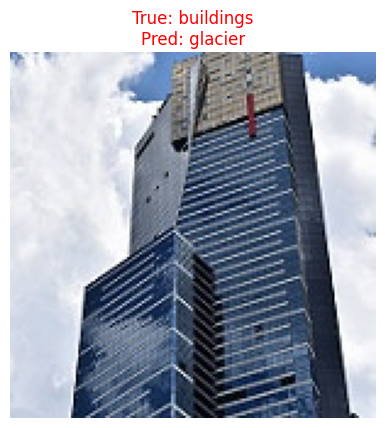

In [15]:

# Plot images with predictions
plt.figure(figsize=(12, 12))
for i in range(min(9, len(x_batch))):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    correct = y_pred_classes[i] == y_true_classes[i]
    color = "green" if correct else "red"
    title = f"True: {class_names[y_true_classes[i]]}\nPred: {class_names[y_pred_classes[i]]}"
    plt.title(title, color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
test_image = {}

test_path = TEST_DIR

for i in os.listdir(test_path):
    category_path = os.path.join(test_path, i)
    if os.path.isdir(category_path):
        test_image[i] = os.listdir(category_path)

print("Augmented data found in each class:")
for k, v in test_image.items():
    print(k, len(v))


Augmented data found in each class:
sea 510
street 501
mountain 525
buildings 437
glacier 553
forest 474


## Improving model

### Data augmentation hanya pada training

### Data generator

In [18]:
TRAIN_DIR_2 = "data/seg_train_2/seg_train" 
TEST_DIR = "data/seg_test/seg_test"

# OPTION 1: Using validation_split
# ----------------------------
# Training data with augmentation and split
train_datagen_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

# Training generator (80% of data)
train_generator = train_datagen_2.flow_from_directory(
    TRAIN_DIR_2,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator (20% of data) WITH NO AUGMENTATION
# We need a separate datagen with only rescaling
val_datagen_2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

validation_generator = val_datagen_2.flow_from_directory(
    TRAIN_DIR_2,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Improved models and callback

In [5]:
def create_improved_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001
    )

    checkpoint_dir = './model_checkpoints_2'

    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint_filepath = os.path.join(checkpoint_dir, 'model_improved_epoch_{epoch:02d}.h5')
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_best_only=False,
        save_freq='epoch',
        verbose=1
    )

    
    return [early_stopping, reduce_lr, checkpoint_callback]

### Training model

In [31]:
improved_model = create_improved_model()
print(improved_model.summary())

callbacks = create_callbacks()

history_2 = improved_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,941,094 (41.74 MB)

 Trainable params: 10,939,430 (41.73 MB)

 Non-trainable params: 1,664 (6.50 KB)

None
Epoch 1/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3920 - loss: 1.9479
Epoch 1: saving model to ./model_checkpoints_2/model_improved_epoch_01.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2759s 8s/step - accuracy: 0.3922 - loss: 1.9471 - val_accuracy: 0.1922 - val_loss: 4.9660 - learning_rate: 1.0000e-04
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5299 - loss: 1.3573
Epoch 2: saving model to ./model_checkpoints_2/model_improved_epoch_02.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2710s 8s/step - accuracy: 0.5299 - loss: 1.3571 - val_accuracy: 0.4914 - val_loss: 2.1312 - learning_rate: 1.0000e-04
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5834 - loss: 1.1948
Epoch 3: saving model to ./model_checkpoints_2/model_improved_epoch_03.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2956s 8s/step - accuracy: 0.5835 - loss: 1.1946 - val_accuracy: 0.4929 - val_loss: 2.3940 - learning_rate: 1.0000e-04
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6056 - loss: 1.0732
Epoch 4: saving model to ./model_checkpoints_2/model_improved_epoch_04.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2888s 8s/step - accuracy: 0.6057 - loss: 1.0732 - val_accuracy: 0.5125 - val_loss: 2.0082 - learning_rate: 1.0000e-04
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6325 - loss: 1.0142
Epoch 5: saving model to ./model_checkpoints_2/model_improved_epoch_05.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2036s 6s/step - accuracy: 0.6325 - loss: 1.0142 - val_accuracy: 0.5460 - val_loss: 1.8888 - learning_rate: 1.0000e-04
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6534 - loss: 0.9547
Epoch 6: saving model to ./model_checkpoints_2/model_improved_epoch_06.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2208s 6s/step - accuracy: 0.6533 - loss: 0.9547 - val_accuracy: 0.5449 - val_loss: 1.7530 - learning_rate: 1.0000e-04
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6746 - loss: 0.8947
Epoch 7: saving model to ./model_checkpoints_2/model_improved_epoch_07.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2975s 8s/step - accuracy: 0.6746 - loss: 0.8947 - val_accuracy: 0.5478 - val_loss: 1.6415 - learning_rate: 1.0000e-04
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6763 - loss: 0.8855
Epoch 8: saving model to ./model_checkpoints_2/model_improved_epoch_08.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2502s 7s/step - accuracy: 0.6763 - loss: 0.8856 - val_accuracy: 0.5196 - val_loss: 1.8794 - learning_rate: 1.0000e-04
Epoch 9/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7032 - loss: 0.8282
Epoch 9: saving model to ./model_checkpoints_2/model_improved_epoch_09.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2417s 7s/step - accuracy: 0.7032 - loss: 0.8282 - val_accuracy: 0.4479 - val_loss: 4.2647 - learning_rate: 1.0000e-04
Epoch 10/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6977 - loss: 0.8262
Epoch 10: saving model to ./model_checkpoints_2/model_improved_epoch_10.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2859s 8s/step - accuracy: 0.6977 - loss: 0.8262 - val_accuracy: 0.5892 - val_loss: 1.4756 - learning_rate: 1.0000e-04
Epoch 11/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7145 - loss: 0.7979 
Epoch 11: saving model to ./model_checkpoints_2/model_improved_epoch_11.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 4191s 12s/step - accuracy: 0.7145 - loss: 0.7978 - val_accuracy: 0.6205 - val_loss: 1.2807 - learning_rate: 1.0000e-04
Epoch 12/30
168/351 ━━━━━━━━━━━━━━━━━━━━ 24:18 8s/step - accuracy: 0.7291 - loss: 0.7390

KeyboardInterrupt: 

### Reload model
tahap ini dilakukan karena waktu yang diperlukan untuk training model sangat lama, sehingga pelatihan dilakukan beberapa kali

In [6]:
# loaded_model = tf.keras.models.load_model('model_checkpoints_2/model_improved_epoch_11.h5')
loaded_model = tf.keras.models.load_model('model_checkpoints_2/model_epoch_21.h5')

model = tf.keras.models.clone_model(loaded_model)

model.set_weights(loaded_model.get_weights())

model.compile(
    optimizer=Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']  
)

2025-04-16 08:10:51.788856: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
checkpoint_dir = './model_checkpoints_2'

os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_improved_epoch_{epoch:02d}.h5')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)


In [12]:
history_3 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    # initial_epoch=7,
    initial_epoch=12,
    callbacks=[checkpoint_callback]
)

model.save('final_model_2.h5')

/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 13/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7118 - loss: 0.7827
Epoch 13: saving model to ./model_checkpoints_2/model_epoch_13.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3705s 11s/step - accuracy: 0.7118 - loss: 0.7827 - val_accuracy: 0.6081 - val_loss: 1.5957
Epoch 14/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7253 - loss: 0.7509 
Epoch 14: saving model to ./model_checkpoints_2/model_epoch_14.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3823s 11s/step - accuracy: 0.7254 - loss: 0.7509 - val_accuracy: 0.5556 - val_loss: 1.7711
Epoch 15/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7349 - loss: 0.7368 
Epoch 15: saving model to ./model_checkpoints_2/model_epoch_15.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3809s 11s/step - accuracy: 0.7349 - loss: 0.7368 - val_accuracy: 0.5945 - val_loss: 1.3275
Epoch 16/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7498 - loss: 0.6909 
Epoch 16: saving model to ./model_checkpoints_2/model_epoch_16.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3781s 11s/step - accuracy: 0.7498 - loss: 0.6909 - val_accuracy: 0.6152 - val_loss: 1.2469
Epoch 17/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7632 - loss: 0.6670 
Epoch 17: saving model to ./model_checkpoints_2/model_epoch_17.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3729s 11s/step - accuracy: 0.7632 - loss: 0.6671 - val_accuracy: 0.5884 - val_loss: 1.3771
Epoch 18/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7699 - loss: 0.6395 
Epoch 18: saving model to ./model_checkpoints_2/model_epoch_18.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3757s 11s/step - accuracy: 0.7699 - loss: 0.6396 - val_accuracy: 0.6648 - val_loss: 1.2807
Epoch 19/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7652 - loss: 0.6394 
Epoch 19: saving model to ./model_checkpoints_2/model_epoch_19.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3870s 11s/step - accuracy: 0.7652 - loss: 0.6394 - val_accuracy: 0.5760 - val_loss: 1.6070
Epoch 20/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7750 - loss: 0.6386 
Epoch 20: saving model to ./model_checkpoints_2/model_epoch_20.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3873s 11s/step - accuracy: 0.7750 - loss: 0.6386 - val_accuracy: 0.6797 - val_loss: 1.1672
Epoch 21/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7744 - loss: 0.6183 
Epoch 21: saving model to ./model_checkpoints_2/model_epoch_21.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3827s 11s/step - accuracy: 0.7744 - loss: 0.6183 - val_accuracy: 0.6444 - val_loss: 1.5439
Epoch 22/30
 94/351 ━━━━━━━━━━━━━━━━━━━━ 45:09 11s/step - accuracy: 0.7742 - loss: 0.6051

KeyboardInterrupt: 

In [11]:
history_4 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    # initial_epoch=7,
    # initial_epoch=12,
    initial_epoch=21,
    callbacks=[checkpoint_callback]
)

model.save('final_model_2.h5')

/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 22/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7894 - loss: 0.5983
Epoch 22: saving model to ./model_checkpoints_2/model_improved_epoch_22.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2523s 7s/step - accuracy: 0.7894 - loss: 0.5983 - val_accuracy: 0.6719 - val_loss: 1.2031
Epoch 23/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7881 - loss: 0.5874
Epoch 23: saving model to ./model_checkpoints_2/model_improved_epoch_23.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2696s 8s/step - accuracy: 0.7881 - loss: 0.5874 - val_accuracy: 0.6148 - val_loss: 1.6408
Epoch 24/30
152/351 ━━━━━━━━━━━━━━━━━━━━ 24:36 7s/step - accuracy: 0.7956 - loss: 0.5795

KeyboardInterrupt: 

In [8]:
loaded_model = tf.keras.models.load_model('model_checkpoints_2/model_improved_epoch_23.h5')
# loaded_model = tf.keras.models.load_model('model_checkpoints_2/model_epoch_21.h5')

model = tf.keras.models.clone_model(loaded_model)

model.set_weights(loaded_model.get_weights())

model.compile(
    optimizer=Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']  
)

2025-04-16 22:08:10.410660: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
history_5 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    # initial_epoch=7,
    # initial_epoch=12,
    # initial_epoch=21,
    initial_epoch=23,
    callbacks=[checkpoint_callback]
)

model.save('final_model_2.h5')

/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 24/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7935 - loss: 0.5650 
Epoch 24: saving model to ./model_checkpoints_2/model_improved_epoch_24.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 4187s 12s/step - accuracy: 0.7935 - loss: 0.5650 - val_accuracy: 0.6929 - val_loss: 1.2774
Epoch 25/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7949 - loss: 0.5833 
Epoch 25: saving model to ./model_checkpoints_2/model_improved_epoch_25.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3904s 11s/step - accuracy: 0.7949 - loss: 0.5833 - val_accuracy: 0.7183 - val_loss: 0.9680
Epoch 26/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8015 - loss: 0.5488 
Epoch 26: saving model to ./model_checkpoints_2/model_improved_epoch_26.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3901s 11s/step - accuracy: 0.8015 - loss: 0.5488 - val_accuracy: 0.6665 - val_loss: 1.3133
Epoch 27/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8031 - loss: 0.5476 
Epoch 27: saving model to ./model_checkpoints_2/model_improved_epoch_27.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3948s 11s/step - accuracy: 0.8031 - loss: 0.5476 - val_accuracy: 0.6655 - val_loss: 1.2149
Epoch 28/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8042 - loss: 0.5501 
Epoch 28: saving model to ./model_checkpoints_2/model_improved_epoch_28.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3962s 11s/step - accuracy: 0.8042 - loss: 0.5501 - val_accuracy: 0.7233 - val_loss: 0.8610
Epoch 29/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8064 - loss: 0.5610 
Epoch 29: saving model to ./model_checkpoints_2/model_improved_epoch_29.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3942s 11s/step - accuracy: 0.8064 - loss: 0.5609 - val_accuracy: 0.7347 - val_loss: 0.9154
Epoch 30/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8157 - loss: 0.5373 
Epoch 30: saving model to ./model_checkpoints_2/model_improved_epoch_30.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 3910s 11s/step - accuracy: 0.8157 - loss: 0.5373 - val_accuracy: 0.7136 - val_loss: 0.9780


### Evaluasi model

In [13]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


88/88 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.7222 - loss: 0.9277
Test Accuracy: 0.7136
Test Loss: 0.9780


In [11]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.7102 - loss: 1.0149
Test Accuracy: 0.6937
Test Loss: 1.0703


In [17]:
print(history_5.history["accuracy"])
print(history_5.history["val_accuracy"])
print(history_5.history["loss"])
print(history_5.history["val_loss"])

[0.788334846496582, 0.7968833446502686, 0.7977738380432129, 0.8034728169441223, 0.8032057285308838, 0.8086375594139099, 0.8154051899909973]
[0.6929386854171753, 0.7182596325874329, 0.6665477752685547, 0.6654778718948364, 0.7232524752616882, 0.7346647381782532, 0.7136234045028687]
[0.5733073353767395, 0.5661513209342957, 0.5569738745689392, 0.5446017980575562, 0.553207278251648, 0.5482375025749207, 0.5277439951896667]
[1.2774156332015991, 0.9679577350616455, 1.3133444786071777, 1.2148971557617188, 0.8609634637832642, 0.915440022945404, 0.9780164361000061]


In [5]:

improved_model = tf.keras.models.load_model('final_model_2.h5')

2025-04-17 09:17:56.895753: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94/94 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.7102 - loss: 1.0149
Test Accuracy: 0.6937
Test Loss: 1.0703
94/94 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step
Class buildings: predicted 293 times (9.77%)
Class forest: predicted 809 times (26.97%)
Class glacier: predicted 271 times (9.03%)
Class mountain: predicted 642 times (21.40%)
Class sea: predicted 756 times (25.20%)
Class street: predicted 229 times (7.63%)
Confusion Matrix:
[[271  49   1  22  63  31]
 [  0 463   2   8   1   0]
 [  2  32 252 151 115   1]
 [  0  17  13 429  66   0]
 [  1  15   3  22 469   0]
 [ 19 233   0  10  42 197]]
Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.62      0.74       437
      forest       0.57      0.98      0.72       474
     glacier       0.93      0.46      0.61       553
    mountain       0.67      0.82      0.74       525
         sea       0.62      0.92      0.74       510
      street       0.86      0.39      0.54       501

    

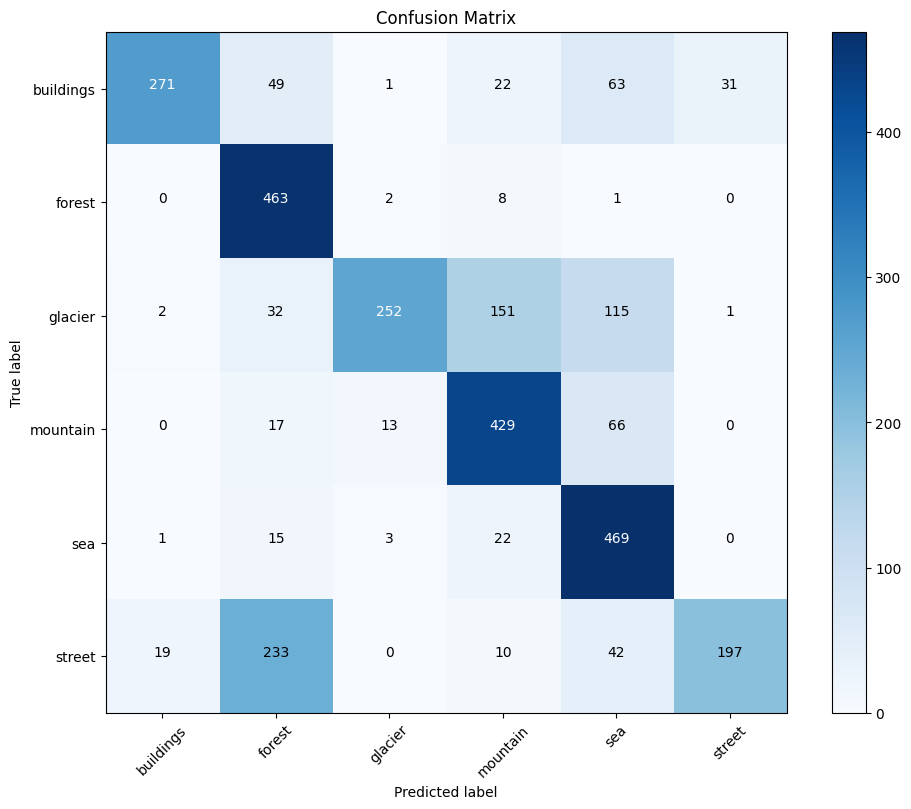

In [19]:
# Evaluate the model
test_loss, test_accuracy = improved_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Analyze predictions
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Get predictions
test_generator.reset()
y_pred = improved_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Print class distribution in predictions
class_names = list(test_generator.class_indices.keys())
for i, class_name in enumerate(class_names):
    print(f"Class {class_name}: predicted {np.sum(y_pred_classes == i)} times ({np.sum(y_pred_classes == i)/len(y_pred_classes):.2%})")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



### Plotting

In [12]:
# Training accuracy values
acc = [0.3922, 0.5299, 0.5835, 0.6057, 0.6325, 0.6533, 0.6746, 0.6763, 0.7032, 0.6977, 0.7145, 0.7291, 0.7118, 0.7254, 0.7349, 0.7498, 0.7632, 0.7699, 0.7652, 0.7750, 0.7744, 0.7894, 0.7881, 0.7935, 0.7949, 0.8015, 0.8031, 0.8042, 0.8064, 0.8157]

# Validation accuracy values
val_acc = [0.1922, 0.4914, 0.4929, 0.5125, 0.5460, 0.5449, 0.5478, 0.5196, 0.4479, 0.5892, 0.6205, None, 0.6081, 0.5556, 0.5945, 0.6152, 0.5884, 0.6648, 0.5760, 0.6797, 0.6444, 0.6719, 0.6148, 0.6929, 0.7183, 0.6665, 0.6655, 0.7233, 0.7347, 0.7136]

# Training loss values
loss = [1.9471, 1.3571, 1.1946, 1.0732, 1.0142, 0.9547, 0.8947, 0.8856, 0.8282, 0.8262, 0.7978, 0.7390, 0.7827, 0.7509, 0.7368, 0.6909, 0.6671, 0.6396, 0.6394, 0.6386, 0.6183, 0.5983, 0.5874, 0.5650, 0.5833, 0.5488, 0.5476, 0.5501, 0.5609, 0.5373]

# Validation loss values
val_loss = [4.9660, 2.1312, 2.3940, 2.0082, 1.8888, 1.7530, 1.6415, 1.8794, 4.2647, 1.4756, 1.2807, None, 1.5957, 1.7711, 1.3275, 1.2469, 1.3771, 1.2807, 1.6070, 1.1672, 1.5439, 1.2031, 1.6408, 1.2774, 0.9680, 1.3133, 1.2149, 0.8610, 0.9154, 0.9780]

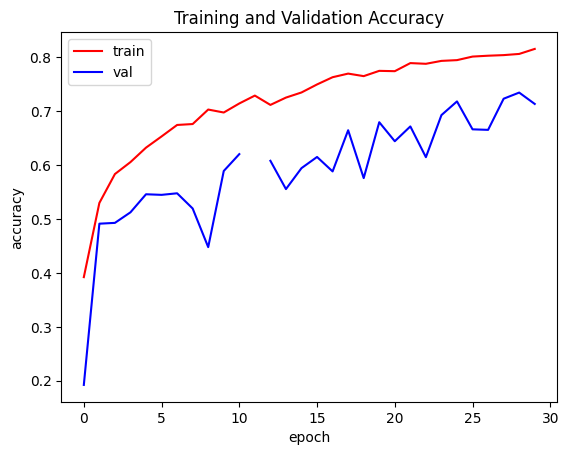

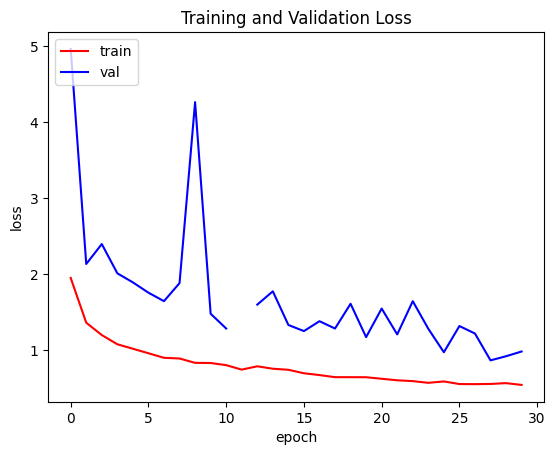

In [14]:
epochs = range(len(acc))
    
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
    
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()



dari plot ini, model terindikasi overfitting karena data training memiliki akurasi bertambah cenderung stabil, dan loss yang berkurang cenderung stabil. Berbeda dengan data validation yang banyak terjadi fluktuasi, serta memiliki akurasi yang lebih rendah dan loss yang lebih tinggi dibandingkan data training

In [8]:
test_loss, test_accuracy = improved_model.evaluate(train_generator)
print(f'Train Accuracy: {test_accuracy:.4f}')
print(f'Train Loss: {test_loss:.4f}')


/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 728s 2s/step - accuracy: 0.7174 - loss: 0.8351
Train Accuracy: 0.7165
Train Loss: 0.8588


In [9]:
test_loss, test_accuracy = improved_model.evaluate(validation_generator)
print(f'Validation Accuracy: {test_accuracy:.4f}')
print(f'Validation Loss: {test_loss:.4f}')


/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7222 - loss: 0.9277
Validation Accuracy: 0.7136
Validation Loss: 0.9780


In [19]:

improved_model = tf.keras.models.load_model('final_model_2.h5')

2025-04-18 00:00:06.891387: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
test_loss, test_accuracy = improved_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.7102 - loss: 1.0149
Test Accuracy: 0.6937
Test Loss: 1.0703


In [22]:
test_loss, test_accuracy = improved_model.evaluate(validation_generator)
print(f'Validation Accuracy: {test_accuracy:.4f}')
print(f'Validation Loss: {test_loss:.4f}')


88/88 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.7222 - loss: 0.9277
Validation Accuracy: 0.7136
Validation Loss: 0.9780


## Menggunakan transfer learning

### Pembuatan model dan callbacks

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_transfer_model():
    # Load the MobileNetV2 model with pre-trained weights
    base_model = MobileNetV2(
        input_shape=(150, 150, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create a new model on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(6, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create callbacks for training
def create_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001
    )

    checkpoint_dir = './model_checkpoints_3'

    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint_filepath = os.path.join(checkpoint_dir, 'model_MobileNetV2_epoch_{epoch:02d}.h5')
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_best_only=False,
        save_freq='epoch',
        verbose=1
    )

    
    return [early_stopping, reduce_lr, checkpoint_callback]

### Training model

In [11]:
transfer_model = create_transfer_model()
print(transfer_model.summary())

callbacks = create_callbacks()

history = transfer_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)


/tmp/ipykernel_7945/1925481010.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,049,798 (11.63 MB)

 Trainable params: 790,278 (3.01 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

None
Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4502 - loss: 1.7573
Epoch 1: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_01.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.4506 - loss: 1.7558 - val_accuracy: 0.8559 - val_loss: 0.3968 - learning_rate: 1.0000e-04
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.7425 - loss: 0.7604
Epoch 2: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_02.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 346s 985ms/step - accuracy: 0.7426 - loss: 0.7603 - val_accuracy: 0.8727 - val_loss: 0.3621 - learning_rate: 1.0000e-04
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.7809 - loss: 0.6650
Epoch 3: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_03.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.7809 - loss: 0.6649 - val_accuracy: 0.8787 - val_loss: 0.3326 - learning_rate: 1.0000e-04
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.7981 - loss: 0.6258
Epoch 4: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_04.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.7981 - loss: 0.6257 - val_accuracy: 0.8841 - val_loss: 0.3282 - learning_rate: 1.0000e-04
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.8002 - loss: 0.5771
Epoch 5: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_05.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.8003 - loss: 0.5770 - val_accuracy: 0.8902 - val_loss: 0.3072 - learning_rate: 1.0000e-04
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8120 - loss: 0.5565
Epoch 6: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_06.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.8121 - loss: 0.5564 - val_accuracy: 0.8927 - val_loss: 0.3004 - learning_rate: 1.0000e-04
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8240 - loss: 0.5064
Epoch 7: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_07.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.8240 - loss: 0.5064 - val_accuracy: 0.8927 - val_loss: 0.2952 - learning_rate: 1.0000e-04
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.8275 - loss: 0.4790
Epoch 8: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_08.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.8274 - loss: 0.4791 - val_accuracy: 0.8941 - val_loss: 0.2912 - learning_rate: 1.0000e-04
Epoch 9/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.8347 - loss: 0.4714
Epoch 9: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_09.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.8347 - loss: 0.4714 - val_accuracy: 0.8951 - val_loss: 0.2896 - learning_rate: 1.0000e-04
Epoch 10/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.8376 - loss: 0.4590
Epoch 10: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_10.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.8376 - loss: 0.4590 - val_accuracy: 0.8951 - val_loss: 0.2859 - learning_rate: 1.0000e-04
Epoch 11/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8337 - loss: 0.4559
Epoch 11: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_11.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.8337 - loss: 0.4559 - val_accuracy: 0.8987 - val_loss: 0.2801 - learning_rate: 1.0000e-04
Epoch 12/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8452 - loss: 0.4180
Epoch 12: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_12.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 213s 606ms/step - accuracy: 0.8452 - loss: 0.4180 - val_accuracy: 0.8959 - val_loss: 0.2837 - learning_rate: 1.0000e-04
Epoch 13/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8433 - loss: 0.4361
Epoch 13: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_13.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 214s 609ms/step - accuracy: 0.8433 - loss: 0.4361 - val_accuracy: 0.8987 - val_loss: 0.2803 - learning_rate: 1.0000e-04
Epoch 14/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.8478 - loss: 0.4220
Epoch 14: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_14.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 250s 713ms/step - accuracy: 0.8478 - loss: 0.4220 - val_accuracy: 0.8955 - val_loss: 0.2859 - learning_rate: 1.0000e-04
Epoch 15/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8472 - loss: 0.4076
Epoch 15: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_15.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 220s 625ms/step - accuracy: 0.8472 - loss: 0.4076 - val_accuracy: 0.8973 - val_loss: 0.2805 - learning_rate: 2.0000e-05
Epoch 16/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8482 - loss: 0.4168
Epoch 16: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_16.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 215s 611ms/step - accuracy: 0.8482 - loss: 0.4168 - val_accuracy: 0.8984 - val_loss: 0.2794 - learning_rate: 2.0000e-05
Epoch 17/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8526 - loss: 0.3991
Epoch 17: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_17.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 216s 614ms/step - accuracy: 0.8526 - loss: 0.3992 - val_accuracy: 0.8994 - val_loss: 0.2781 - learning_rate: 2.0000e-05
Epoch 18/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8471 - loss: 0.4208
Epoch 18: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_18.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 218s 620ms/step - accuracy: 0.8471 - loss: 0.4208 - val_accuracy: 0.8969 - val_loss: 0.2771 - learning_rate: 2.0000e-05
Epoch 19/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8515 - loss: 0.3983
Epoch 19: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_19.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 261s 743ms/step - accuracy: 0.8515 - loss: 0.3983 - val_accuracy: 0.9001 - val_loss: 0.2767 - learning_rate: 2.0000e-05
Epoch 20/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.8530 - loss: 0.4006
Epoch 20: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_20.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 330s 940ms/step - accuracy: 0.8530 - loss: 0.4007 - val_accuracy: 0.8980 - val_loss: 0.2771 - learning_rate: 2.0000e-05


### Evaluasi model

In [12]:
test_loss, test_accuracy = transfer_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 661ms/step - accuracy: 0.9070 - loss: 0.2292
Test Accuracy: 0.9027
Test Loss: 0.2633


### Fine tuning

In [13]:
# Fine-tuning phase: unfreeze some layers and train with a very small learning rate
print("Starting fine-tuning...")
base_model = transfer_model.layers[0]
base_model.trainable = True

Starting fine-tuning...


### Freeze dan recompile

In [14]:
# Freeze all the layers before the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile the model with a much lower learning rate
transfer_model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Continue training

In [15]:
fine_tune_history = transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7874 - loss: 0.5995
Epoch 1: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_01.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.7874 - loss: 0.5994 - val_accuracy: 0.8823 - val_loss: 0.3714 - learning_rate: 1.0000e-05
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8161 - loss: 0.4932
Epoch 2: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_02.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.8161 - loss: 0.4932 - val_accuracy: 0.8898 - val_loss: 0.3387 - learning_rate: 1.0000e-05
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8283 - loss: 0.4944
Epoch 3: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_03.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - accuracy: 0.8283 - loss: 0.4944 - val_accuracy: 0.8937 - val_loss: 0.3195 - learning_rate: 1.0000e-05
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8284 - loss: 0.4768
Epoch 4: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_04.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.8284 - loss: 0.4767 - val_accuracy: 0.8984 - val_loss: 0.2978 - learning_rate: 1.0000e-05
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8392 - loss: 0.4551
Epoch 5: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_05.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - accuracy: 0.8392 - loss: 0.4550 - val_accuracy: 0.8991 - val_loss: 0.2909 - learning_rate: 1.0000e-05
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8400 - loss: 0.4526
Epoch 6: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_06.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.8400 - loss: 0.4525 - val_accuracy: 0.8969 - val_loss: 0.2905 - learning_rate: 1.0000e-05
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8482 - loss: 0.4224
Epoch 7: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_07.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 522s 1s/step - accuracy: 0.8482 - loss: 0.4224 - val_accuracy: 0.8959 - val_loss: 0.2884 - learning_rate: 1.0000e-05
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8556 - loss: 0.4052
Epoch 8: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_08.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.8556 - loss: 0.4052 - val_accuracy: 0.8980 - val_loss: 0.2819 - learning_rate: 1.0000e-05
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8642 - loss: 0.3914
Epoch 9: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_09.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.8642 - loss: 0.3914 - val_accuracy: 0.9012 - val_loss: 0.2765 - learning_rate: 1.0000e-05
Epoch 10/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8611 - loss: 0.3990
Epoch 10: saving model to ./model_checkpoints_3/model_MobileNetV2_epoch_10.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.8611 - loss: 0.3990 - val_accuracy: 0.9041 - val_loss: 0.2703 - learning_rate: 1.0000e-05


### Final evaluation

In [16]:
test_loss, test_accuracy = transfer_model.evaluate(test_generator)
print(f'Final Test Accuracy: {test_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 75s 797ms/step - accuracy: 0.8995 - loss: 0.2504
Final Test Accuracy: 0.8993
Final Test Loss: 0.2673


### Predictions

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


test_generator.reset()
y_pred = transfer_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 825ms/step


### Confusion matrix and plotting

In [ ]:
class_names = list(test_generator.class_indices.keys())
for i, class_name in enumerate(class_names):
    print(f"Class {class_name}: predicted {np.sum(y_pred_classes == i)} times ({np.sum(y_pred_classes == i)/len(y_pred_classes):.2%})")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)

Class buildings: predicted 419 times (13.97%)
Class forest: predicted 480 times (16.00%)
Class glacier: predicted 512 times (17.07%)
Class mountain: predicted 563 times (18.77%)
Class sea: predicted 492 times (16.40%)
Class street: predicted 534 times (17.80%)
Confusion Matrix:
[[390   1   0   0   0  46]
 [  0 469   0   1   1   3]
 [  1   3 447  81  16   5]
 [  2   2  53 456  10   2]
 [  6   4  12  24 461   3]
 [ 20   1   0   1   4 475]]
Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.89      0.91       437
      forest       0.98      0.99      0.98       474
     glacier       0.87      0.81      0.84       553
    mountain       0.81      0.87      0.84       525
         sea       0.94      0.90      0.92       510
      street       0.89      0.95      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90    

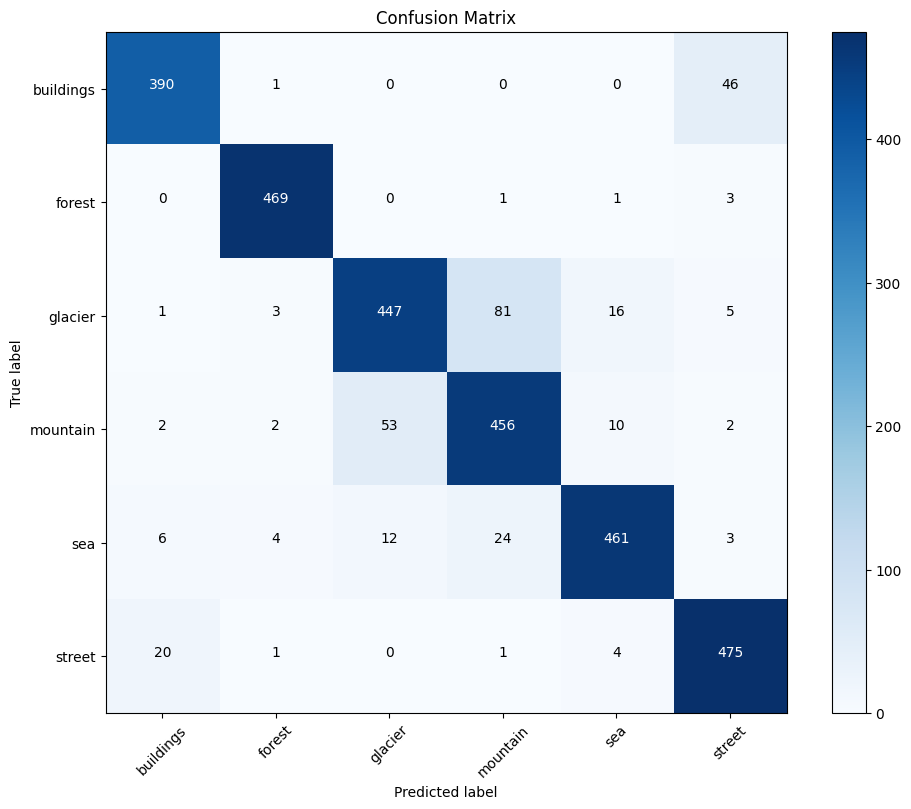

In [19]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

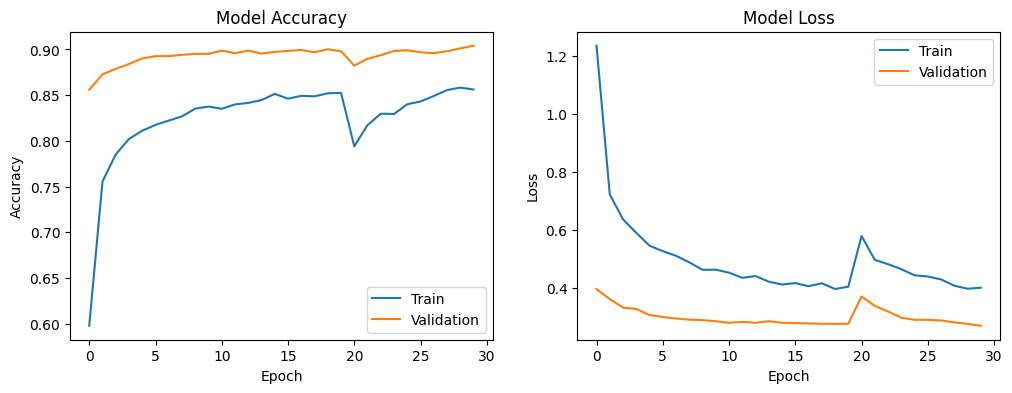

In [20]:
# Combine training histories
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Fine tuning kedua

In [21]:
base_model = transfer_model.layers[0]
base_model.trainable = True

for layer in base_model.layers[:-40]: # layers lebih banyak
    layer.trainable = False

trainable_count = sum(1 for layer in base_model.layers if layer.trainable)
non_trainable_count = sum(1 for layer in base_model.layers if not layer.trainable)
print(f"Trainable layers: {trainable_count}")
print(f"Non-trainable layers: {non_trainable_count}")

Trainable layers: 20
Non-trainable layers: 134


In [22]:
transfer_model.compile(
    optimizer=Adam(learning_rate=0.000005),  # learning rate lebih kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

second_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  
    restore_best_weights=True
)

second_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.000001
)

checkpoint_dir = './model_checkpoints_fine_tune_2'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_MobileNetV2_fine_tune_2_epoch_{epoch:02d}.h5')
second_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    save_best_only=True, # true saja karena waktu yang dibutuhkan untuk training lebih sedikit
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [23]:
second_fine_tune_history = transfer_model.fit(
    train_generator,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[second_early_stopping, second_reduce_lr, second_checkpoint_callback]
)

final_eval = transfer_model.evaluate(validation_generator)
print(f"Final validation accuracy: {final_eval[1]:.4f}")
print(f"Final validation loss: {final_eval[0]:.4f}")

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.8659 - loss: 0.3974
Epoch 1: val_accuracy improved from -inf to 0.90514, saving model to ./model_checkpoints_fine_tune_2/model_MobileNetV2_fine_tune_2_epoch_01.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 300s 807ms/step - accuracy: 0.8659 - loss: 0.3974 - val_accuracy: 0.9051 - val_loss: 0.2672 - learning_rate: 5.0000e-06
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.8581 - loss: 0.4112
Epoch 2: val_accuracy did not improve from 0.90514
351/351 ━━━━━━━━━━━━━━━━━━━━ 301s 856ms/step - accuracy: 0.8581 - loss: 0.4111 - val_accuracy: 0.9041 - val_loss: 0.2683 - learning_rate: 5.0000e-06
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.8631 - loss: 0.3709
Epoch 3: val_accuracy improved from 0.90514 to 0.90621, saving model to ./model_checkpoints_fine_tune_2/model_MobileNetV2_fine_tune_2_epoch_03.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.8631 - loss: 0.3709 - val_accuracy: 0.9062 - val_loss: 0.2620 - learning_rate: 5.0000e-06
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8728 - loss: 0.3678
Epoch 4: val_accuracy improved from 0.90621 to 0.90799, saving model to ./model_checkpoints_fine_tune_2/model_MobileNetV2_fine_tune_2_epoch_04.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.8728 - loss: 0.3678 - val_accuracy: 0.9080 - val_loss: 0.2613 - learning_rate: 5.0000e-06
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8634 - loss: 0.3829
Epoch 5: val_accuracy did not improve from 0.90799
351/351 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.8634 - loss: 0.3829 - val_accuracy: 0.9080 - val_loss: 0.2610 - learning_rate: 5.0000e-06
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8757 - loss: 0.3564
Epoch 6: val_accuracy improved from 0.90799 to 0.90870, saving model to ./model_checkpoints_fine_tune_2/model_MobileNetV2_fine_tune_2_epoch_06.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.8757 - loss: 0.3565 - val_accuracy: 0.9087 - val_loss: 0.2596 - learning_rate: 5.0000e-06
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8683 - loss: 0.3659
Epoch 7: val_accuracy improved from 0.90870 to 0.90942, saving model to ./model_checkpoints_fine_tune_2/model_MobileNetV2_fine_tune_2_epoch_07.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 526s 1s/step - accuracy: 0.8683 - loss: 0.3659 - val_accuracy: 0.9094 - val_loss: 0.2581 - learning_rate: 5.0000e-06
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8747 - loss: 0.3680
Epoch 8: val_accuracy improved from 0.90942 to 0.91013, saving model to ./model_checkpoints_fine_tune_2/model_MobileNetV2_fine_tune_2_epoch_08.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.8747 - loss: 0.3679 - val_accuracy: 0.9101 - val_loss: 0.2584 - learning_rate: 5.0000e-06
Epoch 9/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8769 - loss: 0.3475
Epoch 9: val_accuracy improved from 0.91013 to 0.91227, saving model to ./model_checkpoints_fine_tune_2/model_MobileNetV2_fine_tune_2_epoch_09.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.8769 - loss: 0.3476 - val_accuracy: 0.9123 - val_loss: 0.2586 - learning_rate: 5.0000e-06
Epoch 10/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8650 - loss: 0.3545
Epoch 10: val_accuracy did not improve from 0.91227
351/351 ━━━━━━━━━━━━━━━━━━━━ 662s 2s/step - accuracy: 0.8649 - loss: 0.3545 - val_accuracy: 0.9091 - val_loss: 0.2577 - learning_rate: 5.0000e-06
Epoch 11/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8770 - loss: 0.3567
Epoch 11: val_accuracy did not improve from 0.91227
351/351 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.8770 - loss: 0.3567 - val_accuracy: 0.9116 - val_loss: 0.2559 - learning_rate: 5.0000e-06
Epoch 12/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8741 - loss: 0.3382
Epoch 12: val_accuracy did not improve from 0.91227
351/351 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.8741 - loss: 0.3382 - val_accuracy: 0.9116 - val_loss: 0.2584 - learning_rate: 5.0000e-06
Ep

351/351 ━━━━━━━━━━━━━━━━━━━━ 348s 991ms/step - accuracy: 0.8735 - loss: 0.3454 - val_accuracy: 0.9130 - val_loss: 0.2501 - learning_rate: 5.0000e-06
Epoch 18/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8801 - loss: 0.3425
Epoch 18: val_accuracy improved from 0.91298 to 0.91405, saving model to ./model_checkpoints_fine_tune_2/model_MobileNetV2_fine_tune_2_epoch_18.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.8801 - loss: 0.3425 - val_accuracy: 0.9141 - val_loss: 0.2502 - learning_rate: 5.0000e-06
Epoch 19/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8739 - loss: 0.3485
Epoch 19: val_accuracy did not improve from 0.91405
351/351 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.8739 - loss: 0.3485 - val_accuracy: 0.9126 - val_loss: 0.2515 - learning_rate: 5.0000e-06
Epoch 20/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8758 - loss: 0.3393
Epoch 20: val_accuracy did not improve from 0.91405
351/351 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.8758 - loss: 0.3393 - val_accuracy: 0.9119 - val_loss: 0.2510 - learning_rate: 5.0000e-06
88/88 ━━━━━━━━━━━━━━━━━━━━ 60s 684ms/step - accuracy: 0.9185 - loss: 0.2186
Final validation accuracy: 0.9130
Final validation loss: 0.2501


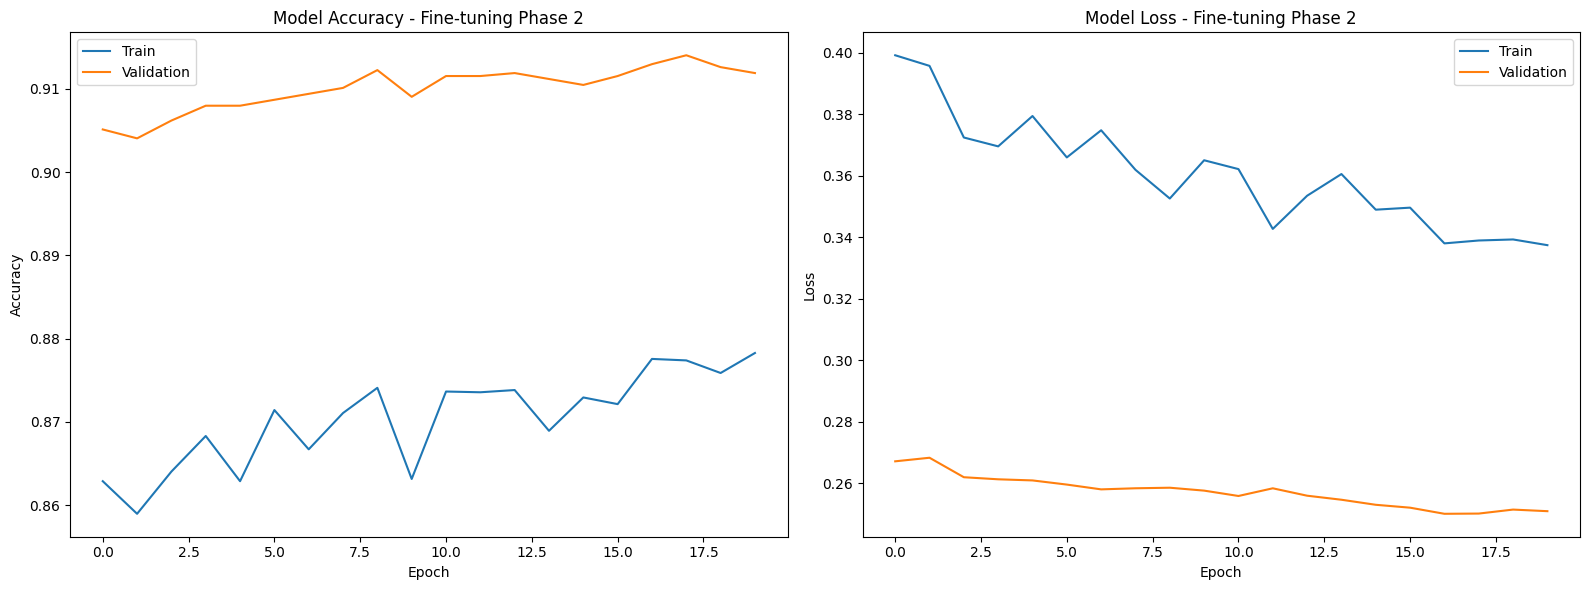

In [24]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(second_fine_tune_history.history['accuracy'], label='Train')
plt.plot(second_fine_tune_history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy - Fine-tuning Phase 2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(second_fine_tune_history.history['loss'], label='Train')
plt.plot(second_fine_tune_history.history['val_loss'], label='Validation')
plt.title('Model Loss - Fine-tuning Phase 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
class_names = list(test_generator.class_indices.keys())
for i, class_name in enumerate(class_names):
    print(f"Class {class_name}: predicted {np.sum(y_pred_classes == i)} times ({np.sum(y_pred_classes == i)/len(y_pred_classes):.2%})")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)

Class buildings: predicted 419 times (13.97%)
Class forest: predicted 480 times (16.00%)
Class glacier: predicted 512 times (17.07%)
Class mountain: predicted 563 times (18.77%)
Class sea: predicted 492 times (16.40%)
Class street: predicted 534 times (17.80%)
Confusion Matrix:
[[390   1   0   0   0  46]
 [  0 469   0   1   1   3]
 [  1   3 447  81  16   5]
 [  2   2  53 456  10   2]
 [  6   4  12  24 461   3]
 [ 20   1   0   1   4 475]]
Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.89      0.91       437
      forest       0.98      0.99      0.98       474
     glacier       0.87      0.81      0.84       553
    mountain       0.81      0.87      0.84       525
         sea       0.94      0.90      0.92       510
      street       0.89      0.95      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90    

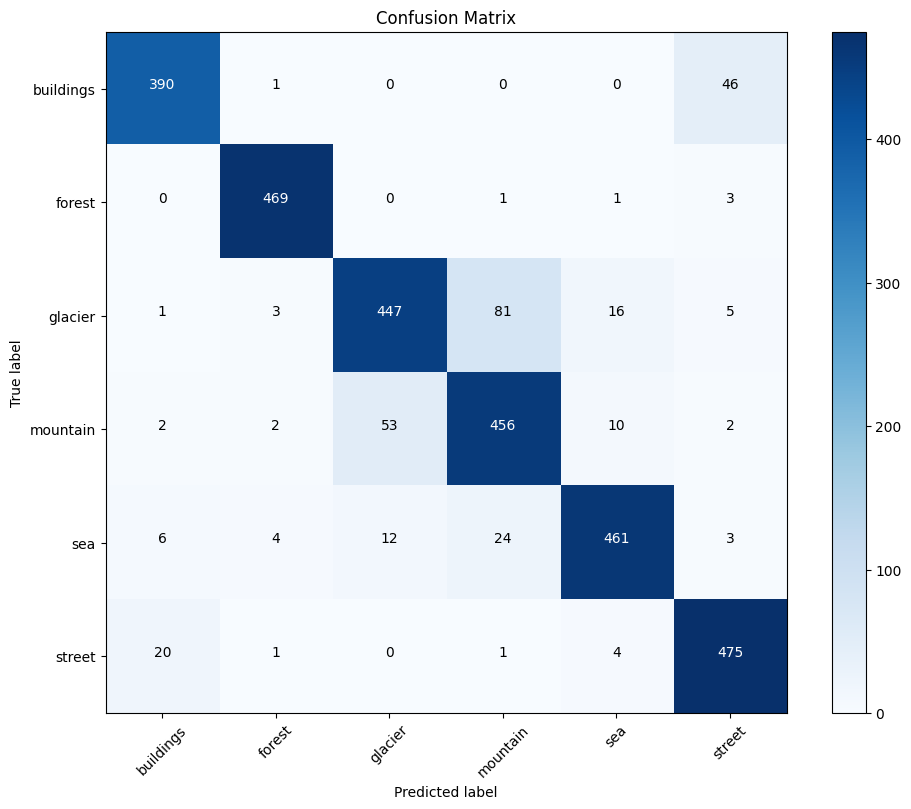

In [26]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Save model

In [28]:
directories = [
    'tfjs_model',
    'tflite',
    'saved_model/variables'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

### saved model

In [33]:
transfer_model.export('saved_model')
print("Model berhasil disimpan dalam format SavedModel")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_505')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137877511241072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511900496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511904192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511901376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511898560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511913168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511909648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511901200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511910352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511911936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511899088

### tflite

In [30]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
with open('tflite/label.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")
print("File label.txt berhasil disimpan")

File label.txt berhasil disimpan


In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(transfer_model)
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model berhasil dikonversi ke TF-Lite")

INFO:tensorflow:Assets written to: /tmp/tmpa5sjk6ky/assets


INFO:tensorflow:Assets written to: /tmp/tmpa5sjk6ky/assets


Saved artifact at '/tmp/tmpa5sjk6ky'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_505')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137877511241072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511900496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511904192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511901376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511898560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511913168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511909648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511901200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511910352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877511911936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378775118

W0000 00:00:1744882637.306550    7945 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744882637.306607    7945 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-17 16:37:17.307150: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpa5sjk6ky
2025-04-17 16:37:17.328711: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-17 16:37:17.328750: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpa5sjk6ky
I0000 00:00:1744882637.597819    7945 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-17 16:37:17.647818: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-17 16:37:19.555035: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpa5sjk6ky
2025-04-17 16:37:20.098996: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

Model berhasil dikonversi ke TF-Lite


### tfjs

In [38]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(transfer_model, 'tfjs_model')
print("Model berhasil dikonversi ke TFJS")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke TFJS
